# Discrete grid infotaxis

Discrete grid infotaxis with precisely one target present in the search space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import xlogy

## Function definitions

### Utility functions

In [2]:
def plot_map(ax,M,minor_ticks_x,minor_ticks_y,opt,cmap='viridis'):
    '''
    Plot probability map
    opt   =1: probability map all d_ij < 1
          =0: not restriction on vmin and vmax
    '''
    # Note how the x and y need to be switched when plotting
    if opt==1:
        im = ax.imshow(M.T,vmin=0,vmax=1,cmap=cmap)
    else:
        im = ax.imshow(M.T,cmap=cmap)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor',alpha=0.4)
    return im

In [3]:
def beam_shape():
    '''
    Generate Beam shape wrt beam axis
    '''
    beam_shape_i = [np.arange(-1,2)]*3
    beam_shape_j = np.copy(beam_shape_i).T
    beam_shape_i = np.reshape(beam_shape_i,(-1,1))
    beam_shape_j = np.reshape(beam_shape_j,(-1,1))
    return np.hstack((beam_shape_i,beam_shape_j))

In [4]:
def clean_beam_cover(cover_ij,d):
    '''
    Remove beam axis entries outside of search space boundary
    '''
    
    # Remove entries outside of boundary
    a = [x>=d.shape[0] or x<0 for x in cover_ij[:,0]]
    b = [y>=d.shape[1] or y<0 for y in cover_ij[:,1]]
    del_idx = np.where(np.array([x or y for x,y in zip(a,b)])==True)
    return np.delete(cover_ij,del_idx,0)

In [5]:
def plot_beam_axis(ax,axis_ij):
    '''
    Plot beam axis on the map
    '''
    ax.plot(axis_ij[0],axis_ij[1],'x',markersize=8,
            markeredgecolor='m',markeredgewidth=2)

In [6]:
def plot_target_loc(ax,axis_ij):
    '''
    Plot target location on the map
    '''
    ax.plot(axis_ij[0],axis_ij[1],'mo',markersize=8,
            markerfacecolor="None",markeredgecolor='m',markeredgewidth=2)

### Functions for updates and selecting next beam

In [7]:
def update_D1(d,axis_ij,pm,pfa):
    '''
    Update dk when an echo was received (D1)
    '''
    # Ravel and copy input D
    dk = d.ravel()        # flattened D matrix
    dk_new = np.copy(dk)  # a copy to store new dk

    # Assemble new beam coverage
    cover_ij = axis_ij + beam_shape()
    cover_ij = clean_beam_cover(cover_ij,d)

    # Get flattened indices
    k_in_B = np.ravel_multi_index((cover_ij[:,0],cover_ij[:,1]),d.shape)  # cells covered by beam
    k_not_in_B = np.setdiff1d(np.arange(d.size),k_in_B,assume_unique=True)   # cells not covered by beam

    # Sanity check
    if np.all(dk_new[k_in_B]==0):  # if dk in all cells are 0
        return d
    else:
        # Quantities
        p_D1_Tk_Bk = 1-pm           # echo received
        p_D1_Tk_B0 = 1-(1-pfa)**k_in_B.size
        # p_D0_Tk_Bk = 1-p_D1_Tk_Bk   # no echo
        # p_D0_Tk_B0 = 1-p_D1_Tk_B0

        # For cells covered by the beam
        for kk in k_in_B:
            dk_new[kk] = p_D1_Tk_Bk * dk[kk]

        # For cells not covered by the beam
        for kk_n in k_not_in_B:
            dk_new[kk_n] = p_D1_Tk_B0 * dk[kk_n]

        # Normalize and reshape to get dk map
        dk_new = dk_new/np.sum(dk_new)
        return np.reshape(dk_new,d.shape)

In [8]:
def update_D0(d,axis_ij,pm,pfa):
    '''
    Update dk when NO echo was received (D0)
    '''
    # Ravel and copy input D
    dk = d.ravel()        # flattened D matrix
    dk_new = np.copy(dk)  # a copy to store new dk

    # Assemble new beam coverage
    cover_ij = axis_ij + beam_shape()
    cover_ij = clean_beam_cover(cover_ij,d)

    # Get flattened indices
    k_in_B = np.ravel_multi_index((cover_ij[:,0],cover_ij[:,1]),d.shape)  # cells covered by beam
    k_not_in_B = np.setdiff1d(np.arange(d.size),k_in_B,assume_unique=True)   # cells not covered by beam

    # Sanity check
    if np.sum(dk_new[k_in_B])==1:  # if dk in all cells are 1
        return d
    else:
        # Quantities
        p_D1_Tk_Bk = 1-pm           # echo received
        p_D1_Tk_B0 = 1-(1-pfa)**k_in_B.size
        p_D0_Tk_Bk = 1-p_D1_Tk_Bk   # no echo
        p_D0_Tk_B0 = 1-p_D1_Tk_B0

        # For cells covered by the beam
        for kk in k_in_B:
            dk_new[kk] = p_D0_Tk_Bk * dk[kk]

        # For cells not covered by the beam
        for kk_n in k_not_in_B:
            dk_new[kk_n] = p_D0_Tk_B0 * dk[kk_n]

        # Normalize and reshape to get dk map
        # The if statement is to avoid the case when all cells outside the beam are 0
        # This case is problematic in the updating only when PM is 0, since in all other
        # cases it is possible that no echo is returned when the target is in the beam
        if np.sum(dk_new)!=0:   
            dk_new = dk_new/np.sum(dk_new)
        return np.reshape(dk_new,d.shape)

In [9]:
def get_S_next(dd):
    '''
    Loop through all possible axis location to calculate the expected S
    '''
    # Loop through all possible axis location
    d_curr = np.copy(dd)   # current mtx D
    dk_curr = d_curr.ravel()   # raveled current dk
    b_ij = np.unravel_index(np.arange(d_curr.size),d_curr.shape)  # all possible next beam axes
    S_next = np.empty(d_curr.shape)  # mtx to store estimated entropy

    for b in np.array(b_ij).T:
    # for (cnt,b) in zip(np.arange(d_curr.size),np.array(b_ij).T):
        # New beam cover
        cover_ij = b + beam_shape()
        cover_ij = clean_beam_cover(cover_ij,d_curr)

        # Estimated D and S
    #     print('beam axis num  %d' % cnt)
        d_est_D1 = update_D1(d_curr,b,pm,pfa)  # next mtx D when received echo
        d_est_D0 = update_D0(d_curr,b,pm,pfa)  # next mtx D when no echo
        d_est_D1 = d_est_D1.ravel()
        d_est_D0 = d_est_D0.ravel()
        # S_D1 = -np.sum( d_est_D1*np.log(d_est_D1) + (1-d_est_D1)*np.log(1-d_est_D1) )
        # S_D0 = -np.sum( d_est_D0*np.log(d_est_D0) + (1-d_est_D0)*np.log(1-d_est_D0) )
        S_D1 = -np.sum( xlogy(d_est_D1,d_est_D1) + xlogy(1-d_est_D1,1-d_est_D1) )  # avoid 0*log0 error
        S_D0 = -np.sum( xlogy(d_est_D0,d_est_D0) + xlogy(1-d_est_D0,1-d_est_D0) )

        # Probability of receiving an echo or not
        # Get flattened indices
        k_in_B = np.ravel_multi_index((cover_ij[:,0],cover_ij[:,1]),d_curr.shape)  # cells in beam
        k_not_in_B = np.setdiff1d(np.arange(d_curr.size),k_in_B,assume_unique=True)  # cells not in beam
        # probability of received an echo = probability of target within beam cover
        p_D1 = np.sum(dk_curr[k_in_B])
        # probability of received an echo = probability of target within beam cover
        p_D0 = np.sum(dk_curr[k_not_in_B])

        # expected entropy
        S_next[b[0],b[1]] = p_D1*S_D1 + p_D0*S_D0
        
    return S_next

In [10]:
def get_next_beam(SS):
    '''
    Select next beam axis among those with lowest entropy
    '''
    SSk_next = SS.ravel()
    SSk_argmin = np.where(SSk_next==np.amin(SSk_next))[0]  # find all argmax locs
    pick_idx = np.random.randint(0,SSk_argmin.size)  # randomly select one argmax point
    return np.unravel_index(SSk_argmin[pick_idx],SS.shape)

In [11]:
def get_hit(beam_ij,M_target):
    '''
    Echolocation and see if return an echo
    '''
    # Generate beam coverage map and plot to check
    cover_ij = beam_ij + beam_shape()
    cover_ij = clean_beam_cover(cover_ij,d)
    M_beam = np.zeros(M_target.shape)
    for icell in cover_ij:
        M_beam[icell[0],icell[1]] = 1

    # find out if an echo was received
    hit = np.any(np.ravel(M_beam)*np.ravel(M_target))
    if hit:
        print('RECEIVED AN ECHO!')
    else:
        print('NO ECHO!')
    return hit

In [12]:
def check_stopping(dd):
    '''
    Checking if the stopping condition is met
    '''
    if np.any(dd>0.9):
        print('FOUND THE TARGET!')
    return np.any(dd>0.9)

## Simulation

### Set up search space dimension and target location

In [13]:
# Set params and target locations
Nx = 10             # dimension 1 of search space
Ny = 10              # dimension 2 of search space
target_xy = [5,3]   # target location
# Nx = 10             # dimension 1 of search space
# Ny = 10              # dimension 2 of search space
# target_xy = [5,3]   # target location
pm = 0.01              # probability of missing
pfa = 0.01             # probability of false alarm

# Calc secondary params
minor_ticks_x = np.arange(Nx+1)-0.5
minor_ticks_y = np.arange(Ny+1)-0.5

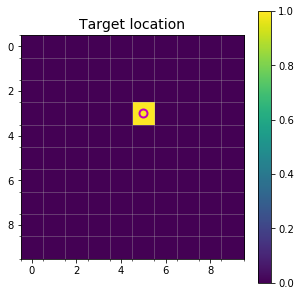

In [14]:
M_target = np.zeros((Nx,Ny)) # map with target in search space
M_target[target_xy[0],target_xy[1]] = 1   # 1 target

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = plot_map(ax,M_target,minor_ticks_x,minor_ticks_y,opt=1)
plot_target_loc(ax,target_xy)  # plot target location
ax.set_title('Target location',fontsize=14)
fig.colorbar(im)
plt.show()

### Initialize matrix D

[[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]]


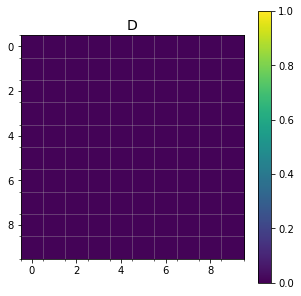

In [15]:
d = 1/(Nx*Ny)*np.ones((Nx,Ny))
print(d)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = plot_map(ax,d,minor_ticks_x,minor_ticks_y,opt=1)
ax.set_title('D',fontsize=14)
fig.colorbar(im)
plt.show()

### Generate initial beam axis and beam coverage

In [16]:
# Randomly generate an initial beam axis
beam_axis_ij = np.unravel_index(np.random.randint(0,Nx*Ny-1),d.shape)
beam_axis_ij

(0, 9)

In [17]:
# # Manually assign start beam axis
# beam_axis_ij = np.array([4,3])

In [18]:
# Generate coverage of the beam
beam_cover_ij = beam_axis_ij + beam_shape()
beam_cover_ij = clean_beam_cover(beam_cover_ij,d)  # clean up locs outside boundary

In [19]:
# Generate beam coverage map and plot to check
M_beam = np.zeros(d.shape)
for icell in beam_cover_ij:
    M_beam[icell[0],icell[1]] = 1

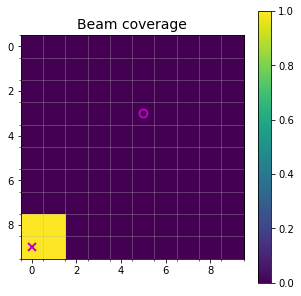

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = plot_map(ax,M_beam,minor_ticks_x,minor_ticks_y,opt=1)
ax.set_title('Beam coverage',fontsize=14)
plot_beam_axis(ax,beam_axis_ij)  # plot beam axis
plot_target_loc(ax,target_xy)  # plot target location
fig.colorbar(im)
plt.show()

### Loop until target is found

In [21]:
%precision 3

'%.3f'

### Use np.concatenate to store results

Echolocate #1
NO ECHO!


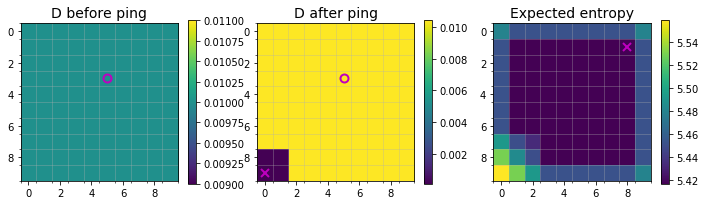

Echolocate #2
NO ECHO!


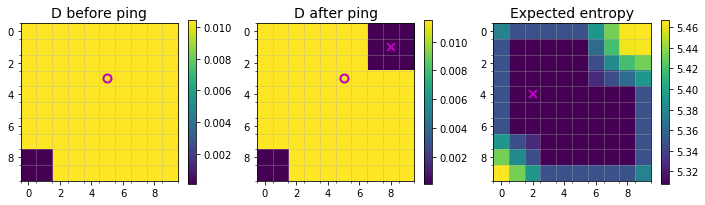

Echolocate #3
NO ECHO!


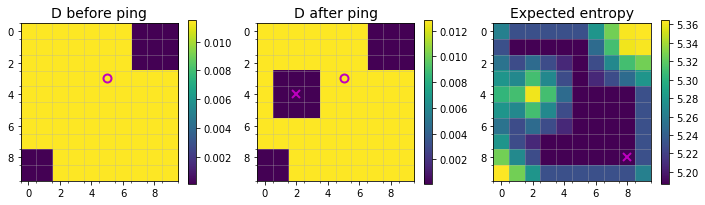

Echolocate #4
NO ECHO!


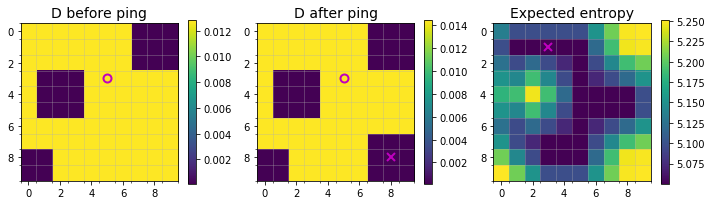

Echolocate #5
NO ECHO!


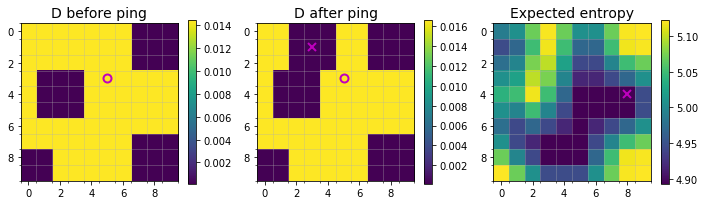

Echolocate #6
NO ECHO!


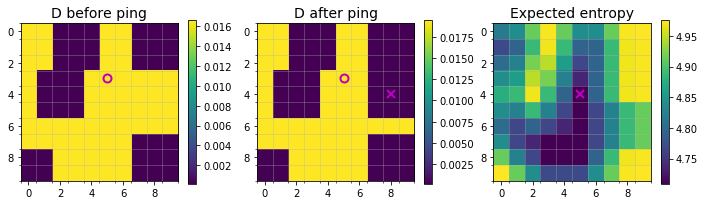

Echolocate #7
RECEIVED AN ECHO!


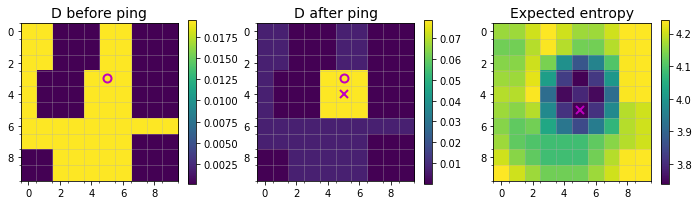

Echolocate #8
NO ECHO!


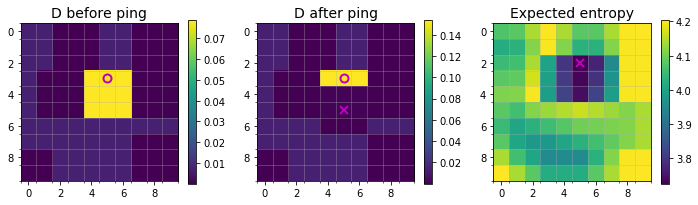

Echolocate #9
RECEIVED AN ECHO!


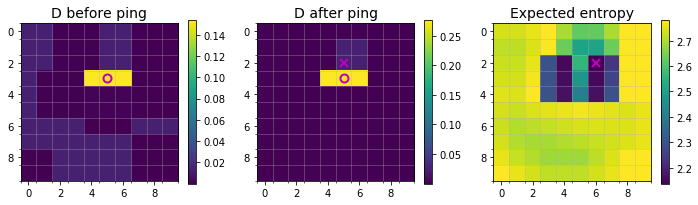

Echolocate #10
RECEIVED AN ECHO!


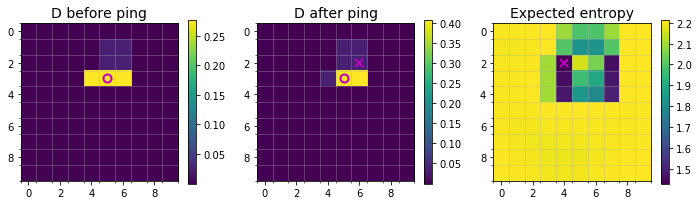

Echolocate #11
RECEIVED AN ECHO!


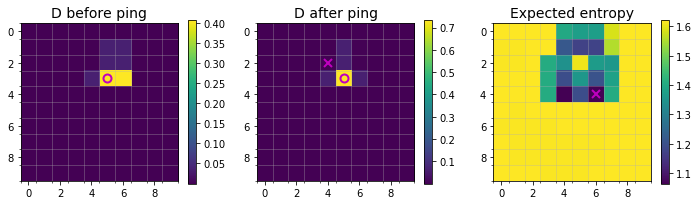

Echolocate #12
RECEIVED AN ECHO!


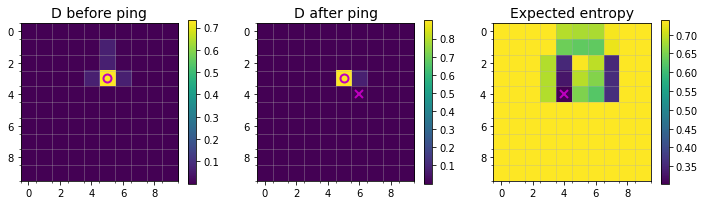

Echolocate #13
RECEIVED AN ECHO!


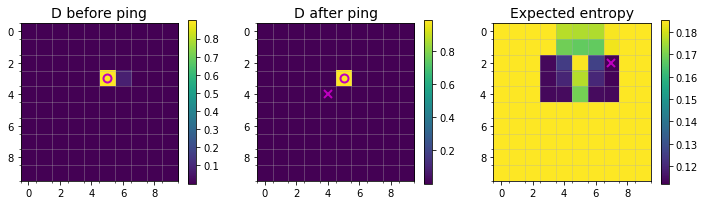

FOUND THE TARGET!


In [22]:
# Initialize the loop
d_next = np.copy(d)
next_beam_ij = np.copy(beam_axis_ij)

# Set up storage variables
d_all = np.copy(d_next)
beam_all = np.copy(next_beam_ij)
S_all = np.zeros(d_next.shape)

cnt = 1  # already initialize the first ping
while not check_stopping(d_next):   # loop when the stopping condition is not met
    print('Echolocate #%d' % cnt)
    d_last = d_next
    last_beam_ij = next_beam_ij
    if get_hit(next_beam_ij,M_target):
        d_next = update_D1(d_next,next_beam_ij,pm,pfa)
    else:
        d_next = update_D0(d_next,next_beam_ij,pm,pfa)

    S_next = get_S_next(d_next)
    next_beam_ij = get_next_beam(S_next)  # select next beam aim
    cnt = cnt+1
    
    # Save === 
    d_all = np.dstack((d_all,d_next))
    beam_all = np.vstack((beam_all,next_beam_ij))
    S_all = np.dstack((S_all,S_next))
    
    # Plot ===
    fig = plt.figure(figsize=(12,3))
    
    # dk before ping
    ax = fig.add_subplot(131)
    im = plot_map(ax,d_last,minor_ticks_x,minor_ticks_y,opt=0)
#     plot_beam_axis(ax,last_beam_ij)  # last beam axis
    plot_target_loc(ax,target_xy)    # target location
    ax.set_title('D before ping',fontsize=14)
    fig.colorbar(im)
    
    # dk after ping
    ax = fig.add_subplot(132)
    im = plot_map(ax,d_next,minor_ticks_x,minor_ticks_y,opt=0)  
    plot_beam_axis(ax,last_beam_ij)  # next beam axis
    plot_target_loc(ax,target_xy)    # target location
    ax.set_title('D after ping',fontsize=14)
    fig.colorbar(im)

    # expected entropy wrt next beam axis
    ax = fig.add_subplot(133)
    im = plot_map(ax,S_next,minor_ticks_x,minor_ticks_y,opt=0)
    ax.set_title('Expected entropy',fontsize=14)
    plot_beam_axis(ax,next_beam_ij)  # next beam axis
    fig.colorbar(im)
    plt.show()

#     print(d_next)

In [23]:
%precision 3

'%.3f'

In [24]:
d_all.shape

(10, 10, 14)

In [25]:
S_all.shape

(10, 10, 14)

In [26]:
beam_all.shape

(14, 2)

## Test using ipywidgets

In [27]:
from ipywidgets import interactive, interact

In [30]:
def draw_updates(ping=7):
    ping = ping-1  # adjust for index starting from 0
    fig = plt.figure(figsize=(12,3))

    # dk before ping
    ax = fig.add_subplot(131)
    im = plot_map(ax,d_all[:,:,ping],minor_ticks_x,minor_ticks_y,opt=0)
    plot_target_loc(ax,target_xy)    # target location
    ax.set_title('D before ping',fontsize=14)
    fig.colorbar(im)
    
    # dk after ping
    ax = fig.add_subplot(132)
    im = plot_map(ax,d_all[:,:,ping+1],minor_ticks_x,minor_ticks_y,opt=0)  
    plot_beam_axis(ax,beam_all[ping+1,:])  # next beam axis
    plot_target_loc(ax,target_xy)    # target location
    ax.set_title('D after ping',fontsize=14)
    fig.colorbar(im)

    # expected entropy wrt next beam axis
    ax = fig.add_subplot(133)
    im = plot_map(ax,S_all[:,:,ping],minor_ticks_x,minor_ticks_y,opt=0)
    ax.set_title('Expected entropy',fontsize=14)
    plot_beam_axis(ax,beam_all[ping+1,:])  # next beam axis
    fig.colorbar(im)
    plt.show()

In [32]:
ip = interactive(draw_updates,ping=(0,beam_all.shape[0]-1))
ip

interactive(children=(IntSlider(value=7, description='ping', max=13), Output()), _dom_classes=('widget-interac…